In [ ]:
import numpy as np
import pandas as pd
import lightgbm as lgb
from sklearn.metrics import mean_squared_error, mean_absolute_error

# --------------------------
# Config
# --------------------------
DATA_PATH = "../../final_data/data_260125_control.csv"
DATE_COL = "experiment_date"

TARGET_WEEKS = [pd.Timestamp("2026-01-05")]

Y_COLS = ["nonrepeat_cnt_per_user", "trip_cnt_per_user"]

CAT_COLS = ["ops_type_merged", "city_group"]

NUM_FEATURES = [
    "avg_rainy_day",
    "avg_rainy_weekday",
    "avg_rainy_weekend",
    "mgm_day",
    "nonrepeat_cnt_per_user_lag2",
    "nonrepeat_cnt_per_user_roll4",
    "trip_cnt_per_user_lag2",
    "trip_cnt_per_user_roll4",
    "weekday_nonrepeat_cnt_per_user_lag2",
    "weekday_nonrepeat_cnt_per_user_roll4",
    "weekday_trip_cnt_per_user_lag2",
    "weekday_trip_cnt_per_user_roll4",
    "weekday_match_rate_lag2",
    "weekday_match_rate_roll4",
    "weekend_nonrepeat_cnt_per_user_lag2",
    "weekend_nonrepeat_cnt_per_user_roll4",
    "weekend_trip_cnt_per_user_lag2",
    "weekend_trip_cnt_per_user_roll4",
    "weekend_match_rate_lag2",
    "weekend_match_rate_roll4",
    "has_national_holiday",
    "coupon_BD_per_user_log1p_lag2",
    "coupon_BD_per_user_log1p_roll4",
    "coupon_CDP_per_user_log1p_lag2",
    "coupon_CDP_per_user_log1p_roll4",
    "coupon_folk_per_user_log1p_lag2",
    "coupon_folk_per_user_log1p_roll4",
    "coupon_growth_other_per_user_log1p_lag2",
    "coupon_growth_other_per_user_log1p_roll4",
    "coupon_MGM_per_user_log1p_lag2",
    "coupon_MGM_per_user_log1p_roll4",
    "coupon_MKT_per_user_log1p_lag2",
    "coupon_MKT_per_user_log1p_roll4",
    "coupon_register_per_user_log1p_lag2",
    "coupon_register_per_user_log1p_roll4",
    "coupon_daily_per_user_log1p_lag2",
    "coupon_daily_per_user_log1p_roll4",
]

# --------------------------
# Per-target params (兩套模型參數)
# --------------------------
PARAMS_BY_Y = {
    "trip_cnt_per_user": dict(
        objective="regression",
        n_estimators=3000,
        learning_rate=0.065,
        num_leaves=15,
        min_child_samples=180,
        subsample=0.85,
        colsample_bytree=0.8,
        reg_alpha=0.74,
        reg_lambda=4.69,
        random_state=42,
        n_jobs=-1,
        verbose=-1,
    ),
    "nonrepeat_cnt_per_user": dict(
        objective="regression",
        n_estimators=1800,
        learning_rate=0.03,
        num_leaves=35,
        min_child_samples=100,
        subsample=0.9,
        colsample_bytree=0.8,
        reg_alpha=0,
        reg_lambda=2.4,
        random_state=42,
        n_jobs=-1,
        verbose=-1,
    ),
}

# --------------------------
# Load
# --------------------------
df = pd.read_csv(DATA_PATH)
df[DATE_COL] = pd.to_datetime(df[DATE_COL], errors="coerce")
df = df[df[DATE_COL].notna()].copy()
df = df[df[DATE_COL] <= max(TARGET_WEEKS)].copy()

for c in CAT_COLS:
    if c in df.columns:
        df[c] = df[c].astype("category")

missing_num = [c for c in NUM_FEATURES if c not in df.columns]
missing_cat = [c for c in CAT_COLS if c not in df.columns]
if missing_cat:
    print("[WARN] Missing categorical cols (will be dropped):", missing_cat)
if missing_num:
    print("[WARN] Missing numeric features (will be dropped):", missing_num)

X_COLS = [c for c in CAT_COLS if c in df.columns] + [c for c in NUM_FEATURES if c in df.columns]
CAT_IN_X = [c for c in CAT_COLS if c in df.columns]

# --------------------------
# Helpers
# --------------------------
def rmse(y_true, y_pred) -> float:
    return float(np.sqrt(mean_squared_error(y_true, y_pred)))

def mae(y_true, y_pred) -> float:
    return float(mean_absolute_error(y_true, y_pred))

def fit_predict_one_week(df_all: pd.DataFrame, target_week: pd.Timestamp, y_col: str):
    train_df = df_all[df_all[DATE_COL] < target_week].copy()
    test_df  = df_all[df_all[DATE_COL] == target_week].copy()

    train_df = train_df[train_df[y_col].notna()].copy()
    test_df  = test_df[test_df[y_col].notna()].copy()

    if len(train_df) == 0 or len(test_df) == 0:
        return None, None, len(train_df), len(test_df)

    X_train = train_df[X_COLS]
    y_train = train_df[y_col].astype(float)

    X_test = test_df[X_COLS]
    y_test = test_df[y_col].astype(float)

    if y_col not in PARAMS_BY_Y:
        raise ValueError(f"Missing params for y_col={y_col}. Please set PARAMS_BY_Y['{y_col}'].")

    model = lgb.LGBMRegressor(**PARAMS_BY_Y[y_col])

    model.fit(
        X_train, y_train,
        categorical_feature=[c for c in CAT_IN_X if c in X_train.columns],
    )

    y_pred = model.predict(X_test)
    return y_test.values, y_pred, len(train_df), len(test_df)

# --------------------------
# Run + Print metrics
# --------------------------
for y_col in Y_COLS:
    print(f"\n==================== {y_col} ====================")
    all_y_true = []
    all_y_pred = []

    for tw in TARGET_WEEKS:
        y_true, y_pred, n_tr, n_te = fit_predict_one_week(df, tw, y_col)
        if y_true is None:
            print(f"[{tw.date()}] SKIP (train_rows={n_tr:,}, test_rows={n_te:,})")
            continue

        r = rmse(y_true, y_pred)
        m = mae(y_true, y_pred)
        print(f"[{tw.date()}] train_rows={n_tr:,} test_rows={n_te:,}  RMSE={r:.6f}  MAE={m:.6f}")

        all_y_true.append(y_true)
        all_y_pred.append(y_pred)

    if all_y_true:
        all_y_true = np.concatenate(all_y_true)
        all_y_pred = np.concatenate(all_y_pred)
        print(f"[Overall] test_rows={len(all_y_true):,}  RMSE={rmse(all_y_true, all_y_pred):.6f}  MAE={mae(all_y_true, all_y_pred):.6f}")



==================== nonrepeat_cnt_per_user ====================
[2026-01-05] train_rows=528 test_rows=24  RMSE=0.039343  MAE=0.032137
[Overall] test_rows=24  RMSE=0.039343  MAE=0.032137

==================== trip_cnt_per_user ====================
[2026-01-05] train_rows=528 test_rows=24  RMSE=0.022762  MAE=0.018696
[Overall] test_rows=24  RMSE=0.022762  MAE=0.018696


In [12]:
# ==========================
# Optuna tuning for CONTROL
# - Tune separately for each target in Y_COLS
# - Objective: avg RMSE over 2026-01-05
# - Training constraint: ONLY use data strictly before each target week
# - No saving files, just print best + per-week metrics
# ==========================

import optuna
optuna.logging.set_verbosity(optuna.logging.WARNING)

# ---- baseline params (center of search)
BASE_PARAMS = dict(
    objective="regression",
    n_estimators=3000,
    learning_rate=0.05,
    num_leaves=115,
    min_child_samples=180,
    subsample=0.85,
    colsample_bytree=0.9,
    bagging_freq=5,
    reg_alpha=0.5,
    reg_lambda=2.0,
    random_state=42,
    n_jobs=-1,
    verbose=-1,
)

def fit_predict_one_week_with_params(df_all: pd.DataFrame, target_week: pd.Timestamp, y_col: str, model_params: dict):
    train_df = df_all[df_all[DATE_COL] < target_week].copy()
    test_df  = df_all[df_all[DATE_COL] == target_week].copy()

    train_df = train_df[train_df[y_col].notna()].copy()
    test_df  = test_df[test_df[y_col].notna()].copy()

    if len(train_df) == 0 or len(test_df) == 0:
        return None, None, len(train_df), len(test_df)

    X_train = train_df[X_COLS]
    y_train = train_df[y_col].astype(float)

    X_test = test_df[X_COLS]
    y_test = test_df[y_col].astype(float)

    model = lgb.LGBMRegressor(**model_params)
    model.fit(
        X_train, y_train,
        categorical_feature=[c for c in CAT_IN_X if c in X_train.columns],
    )
    y_pred = model.predict(X_test)
    return y_test.values, y_pred, len(train_df), len(test_df)

def tune_one_target(y_col: str, n_trials: int = 60):
    def objective(trial: optuna.Trial) -> float:
        params = dict(BASE_PARAMS)

        # --- search space near your baseline (and sensible)
        params["learning_rate"] = trial.suggest_float("learning_rate", 0.02, 0.08, log=True)
        params["n_estimators"]  = trial.suggest_int("n_estimators", 1200, 4500, step=300)

        params["num_leaves"] = trial.suggest_int("num_leaves", 15, 127, step=4)
        params["min_child_samples"] = trial.suggest_int("min_child_samples", 20, 200, step=10)

        params["subsample"] = trial.suggest_float("subsample", 0.65, 1.0, step=0.05)
        params["colsample_bytree"] = trial.suggest_float("colsample_bytree", 0.6, 1.0, step=0.05)

        # bagging_freq: keep small (0/1/2/5) - your baseline uses 1
        params["bagging_freq"] = trial.suggest_categorical("bagging_freq", [0, 1, 2, 5])

        # regularization near baseline
        params["reg_alpha"] = trial.suggest_float("reg_alpha", 0.0, 3.0)
        params["reg_lambda"] = trial.suggest_float("reg_lambda", 0.0, 8.0)

        rmses = []
        for i, tw in enumerate(TARGET_WEEKS, start=1):
            y_true, y_pred, n_tr, n_te = fit_predict_one_week_with_params(df, tw, y_col, params)
            if y_true is None or len(y_true) == 0:
                return 1e9
            rmses.append(rmse(y_true, y_pred))

            trial.report(float(np.mean(rmses)), step=i)
            if trial.should_prune():
                raise optuna.TrialPruned()

        return float(np.mean(rmses))

    sampler = optuna.samplers.TPESampler(seed=42)
    pruner = optuna.pruners.MedianPruner(n_startup_trials=10, n_warmup_steps=0)
    study = optuna.create_study(direction="minimize", sampler=sampler, pruner=pruner)

    study.optimize(objective, n_trials=n_trials, show_progress_bar=True)

    print(f"\n===== Optuna Best ({y_col}) =====")
    print("Best RMSE (avg over 2 weeks):", study.best_value)
    print("Best params:", study.best_params)

    best_params = dict(BASE_PARAMS)
    best_params.update(study.best_params)

    # ---- evaluate best params with RMSE + MAE per-week + overall
    print(f"\n==================== {y_col} (BEST params) ====================")
    all_y_true, all_y_pred = [], []
    for tw in TARGET_WEEKS:
        y_true, y_pred, n_tr, n_te = fit_predict_one_week_with_params(df, tw, y_col, best_params)
        if y_true is None:
            print(f"[{tw.date()}] SKIP (train_rows={n_tr:,}, test_rows={n_te:,})")
            continue
        print(f"[{tw.date()}] train_rows={n_tr:,} test_rows={n_te:,} RMSE={rmse(y_true, y_pred):.6f} MAE={mae(y_true, y_pred):.6f}")
        all_y_true.append(y_true)
        all_y_pred.append(y_pred)

    if all_y_true:
        all_y_true = np.concatenate(all_y_true)
        all_y_pred = np.concatenate(all_y_pred)
        print(f"[Overall] test_rows={len(all_y_true):,} RMSE={rmse(all_y_true, all_y_pred):.6f} MAE={mae(all_y_true, all_y_pred):.6f}")

    return study


# --------------------------
# Run tuning separately for two targets
# --------------------------
study_trip = tune_one_target("trip_cnt_per_user", n_trials=60)
study_nonrepeat = tune_one_target("nonrepeat_cnt_per_user", n_trials=60)


  0%|          | 0/60 [00:00<?, ?it/s]


===== Optuna Best (trip_cnt_per_user) =====
Best RMSE (avg over 2 weeks): 0.020645367095009765
Best params: {'learning_rate': 0.06540980952143935, 'n_estimators': 3000, 'num_leaves': 15, 'min_child_samples': 180, 'subsample': 0.8500000000000001, 'colsample_bytree': 0.8, 'bagging_freq': 2, 'reg_alpha': 0.7464287297190387, 'reg_lambda': 4.685109417650222}

==================== trip_cnt_per_user (BEST params) ====================
[2026-01-05] train_rows=528 test_rows=24 RMSE=0.020645 MAE=0.016243
[Overall] test_rows=24 RMSE=0.020645 MAE=0.016243


  0%|          | 0/60 [00:00<?, ?it/s]


===== Optuna Best (nonrepeat_cnt_per_user) =====
Best RMSE (avg over 2 weeks): 0.03558710782987623
Best params: {'learning_rate': 0.03225573201792314, 'n_estimators': 1800, 'num_leaves': 35, 'min_child_samples': 100, 'subsample': 0.9, 'colsample_bytree': 0.8, 'bagging_freq': 0, 'reg_alpha': 2.4210973801227653, 'reg_lambda': 3.645414094821471}

==================== nonrepeat_cnt_per_user (BEST params) ====================
[2026-01-05] train_rows=528 test_rows=24 RMSE=0.035587 MAE=0.030126
[Overall] test_rows=24 RMSE=0.035587 MAE=0.030126


In [13]:
import numpy as np
import pandas as pd
import lightgbm as lgb

# ==========================
# Build prediction table CSV for 2026-01-05 (CONTROL)
# - Use Optuna best params: study_trip / study_nonrepeat
# - Grain: (experiment_date, ops_type_merged, city_group)
# - Values: actual + baseline(lag1/roll4) + LGBM preds
# - If duplicates: simple mean (unweighted)
# ==========================

# --------------------------
# Config (match your CONTROL script)
# --------------------------
DATA_PATH = "../../final_data/data_260125_control.csv"   # 你的路徑
# 若你在這個 ChatGPT 環境跑，改成：
# DATA_PATH = "/mnt/data/data_260125_control.csv"

DATE_COL = "experiment_date"
TEST_WEEK = pd.Timestamp("2026-01-05")

KEY_COLS = ["experiment_date", "ops_type_merged", "city_group"]

Y1 = "trip_cnt_per_user"
Y2 = "nonrepeat_cnt_per_user"

# baseline columns (你說沒錯，就用這些)
Y1_LAG1_COL = "trip_cnt_per_user_lag1"
Y1_ROLL4_COL = "trip_cnt_per_user_roll4"
Y2_LAG1_COL = "nonrepeat_cnt_per_user_lag1"
Y2_ROLL4_COL = "nonrepeat_cnt_per_user_roll4"

# 你的 control 設定是只放兩個 categorical
CAT_COLS = ["ops_type_merged", "city_group"]

# 你的 control NUM_FEATURES（請保持跟你原本一致）
NUM_FEATURES = [
    "avg_rainy_day",
    "avg_rainy_weekday",
    "avg_rainy_weekend",
    "mgm_day",
    "nonrepeat_cnt_per_user_lag2",
    "nonrepeat_cnt_per_user_roll4",
    "trip_cnt_per_user_lag2",
    "trip_cnt_per_user_roll4",
    "weekday_nonrepeat_cnt_per_user_lag2",
    "weekday_nonrepeat_cnt_per_user_roll4",
    "weekday_trip_cnt_per_user_lag2",
    "weekday_trip_cnt_per_user_roll4",
    "weekday_match_rate_lag2",
    "weekday_match_rate_roll4",
    "weekend_nonrepeat_cnt_per_user_lag2",
    "weekend_nonrepeat_cnt_per_user_roll4",
    "weekend_trip_cnt_per_user_lag2",
    "weekend_trip_cnt_per_user_roll4",
    "weekend_match_rate_lag2",
    "weekend_match_rate_roll4",
    "has_national_holiday",
    "coupon_BD_per_user_log1p_lag2",
    "coupon_BD_per_user_log1p_roll4",
    "coupon_CDP_per_user_log1p_lag2",
    "coupon_CDP_per_user_log1p_roll4",
    "coupon_folk_per_user_log1p_lag2",
    "coupon_folk_per_user_log1p_roll4",
    "coupon_growth_other_per_user_log1p_lag2",
    "coupon_growth_other_per_user_log1p_roll4",
    "coupon_MGM_per_user_log1p_lag2",
    "coupon_MGM_per_user_log1p_roll4",
    "coupon_MKT_per_user_log1p_lag2",
    "coupon_MKT_per_user_log1p_roll4",
    "coupon_register_per_user_log1p_lag2",
    "coupon_register_per_user_log1p_roll4",
    "coupon_daily_per_user_log1p_lag2",
    "coupon_daily_per_user_log1p_roll4",
    "delta_trip_per_user",
    "delta_nonrepeat_per_user",
]

OUT_PATH = "../../result/control_v2/control_predictions_full_v2.csv"

# --------------------------
# Load
# --------------------------
df = pd.read_csv(DATA_PATH)
df[DATE_COL] = pd.to_datetime(df[DATE_COL], errors="coerce")
df = df[df[DATE_COL].notna()].copy()
df = df[df[DATE_COL] <= TEST_WEEK].copy()

# categorical cast
for c in CAT_COLS:
    if c in df.columns:
        df[c] = df[c].astype("category")

# feature availability check
missing_num = [c for c in NUM_FEATURES if c not in df.columns]
missing_cat = [c for c in CAT_COLS if c not in df.columns]
if missing_cat:
    print("[WARN] Missing categorical cols (will be dropped):", missing_cat)
if missing_num:
    print("[WARN] Missing numeric features (will be dropped):", missing_num)

X_COLS = [c for c in CAT_COLS if c in df.columns] + [c for c in NUM_FEATURES if c in df.columns]
CAT_IN_X = [c for c in CAT_COLS if c in df.columns]

for col in [Y1_LAG1_COL, Y1_ROLL4_COL, Y2_LAG1_COL, Y2_ROLL4_COL]:
    if col not in df.columns:
        print(f"[WARN] Baseline column missing: {col} (will be NaN in output)")

# --------------------------
# Utils
# --------------------------
def align_categories(train_df: pd.DataFrame, test_df: pd.DataFrame, cat_cols):
    for c in cat_cols:
        if c in train_df.columns and c in test_df.columns:
            train_df[c] = train_df[c].astype("category")
            test_df[c] = test_df[c].astype("category")
            test_df[c] = test_df[c].cat.set_categories(train_df[c].cat.categories)
    return train_df, test_df

def fit_predict(df_all: pd.DataFrame, week: pd.Timestamp, y_col: str, params: dict):
    train_df = df_all[df_all[DATE_COL] < week].copy()
    test_df  = df_all[df_all[DATE_COL] == week].copy()

    train_df = train_df[train_df[y_col].notna()].copy()
    test_df  = test_df[test_df[y_col].notna()].copy()

    train_df, test_df = align_categories(train_df, test_df, CAT_IN_X)

    X_train = train_df[X_COLS]
    y_train = train_df[y_col].astype(float)

    X_test = test_df[X_COLS]
    model = lgb.LGBMRegressor(**params)
    model.fit(X_train, y_train, categorical_feature=[c for c in CAT_IN_X if c in X_train.columns])

    pred = model.predict(X_test)
    return test_df, pred

# --------------------------
# Get best params from Optuna studies
# (你已經跑完 tune_one_target 會有 study_trip / study_nonrepeat)
# --------------------------
try:
    base_params = dict(
        objective="regression",
        random_state=42,
        n_jobs=-1,
        verbose=-1,
    )
    best_params_y1 = dict(base_params)
    best_params_y1.update(study_trip.best_params)          # trip_cnt_per_user
    best_params_y2 = dict(base_params)
    best_params_y2.update(study_nonrepeat.best_params)     # nonrepeat_cnt_per_user
except NameError:
    raise NameError(
        "找不到 study_trip / study_nonrepeat。\n"
        "請確認你已經先跑完 optuna，或把 best_params dict 直接貼到 best_params_y1 / best_params_y2。"
    )

# --------------------------
# Predict
# --------------------------
test_y1_df, pred_y1 = fit_predict(df, TEST_WEEK, Y1, best_params_y1)
test_y2_df, pred_y2 = fit_predict(df, TEST_WEEK, Y2, best_params_y2)

# keep only needed cols + rename
cols_y1 = [c for c in KEY_COLS if c in test_y1_df.columns] + [Y1, Y1_LAG1_COL, Y1_ROLL4_COL]
cols_y1 = [c for c in cols_y1 if c in test_y1_df.columns]
tmp1 = test_y1_df[cols_y1].copy()
tmp1.rename(columns={
    DATE_COL: "experiment_date",
    Y1: "trip_cnt_per_user",
    Y1_LAG1_COL: "pred_y1_lag1",
    Y1_ROLL4_COL: "pred_y1_roll4",
}, inplace=True)
tmp1["pred_y1_lgbm"] = pred_y1

cols_y2 = [c for c in KEY_COLS if c in test_y2_df.columns] + [Y2, Y2_LAG1_COL, Y2_ROLL4_COL]
cols_y2 = [c for c in cols_y2 if c in test_y2_df.columns]
tmp2 = test_y2_df[cols_y2].copy()
tmp2.rename(columns={
    DATE_COL: "experiment_date",
    Y2: "nonrepeat_cnt_per_user",
    Y2_LAG1_COL: "pred_y2_lag1",
    Y2_ROLL4_COL: "pred_y2_roll4",
}, inplace=True)
tmp2["pred_y2_lgbm"] = pred_y2

# outer merge (handles missingness differences between Y1/Y2 rows)
on_cols = [c for c in KEY_COLS if c in tmp1.columns and c in tmp2.columns]
out = tmp1.merge(tmp2, on=on_cols, how="outer")

# --------------------------
# If duplicate keys exist -> simple mean (unweighted)
# --------------------------
need_cols = [
    "trip_cnt_per_user","pred_y1_lag1","pred_y1_roll4","pred_y1_lgbm",
    "nonrepeat_cnt_per_user","pred_y2_lag1","pred_y2_roll4","pred_y2_lgbm",
]
exist_cols = [c for c in need_cols if c in out.columns]

out = (
    out.groupby(KEY_COLS, as_index=False)[exist_cols]
       .mean()
)

# --------------------------
# Column order exactly as requested (CONTROL)
# --------------------------
final_cols = [
    "experiment_date","ops_type_merged","city_group",
    "trip_cnt_per_user","pred_y1_lag1","pred_y1_roll4","pred_y1_lgbm",
    "nonrepeat_cnt_per_user","pred_y2_lag1","pred_y2_roll4","pred_y2_lgbm",
]
for c in final_cols:
    if c not in out.columns:
        out[c] = np.nan

out = out[final_cols].sort_values(KEY_COLS).reset_index(drop=True)

# --------------------------
# Save CSV
# --------------------------
out.to_csv(OUT_PATH, index=False, encoding="utf-8-sig")
print("Saved:", OUT_PATH)


Saved: ../../result/control_v2/control_predictions_full_v2.csv


/var/folders/5k/wdr6l04n13xbrtz6l93pdqmc0000gn/T/ipykernel_55987/1742751410.py:204: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  out.groupby(KEY_COLS, as_index=False)[exist_cols]


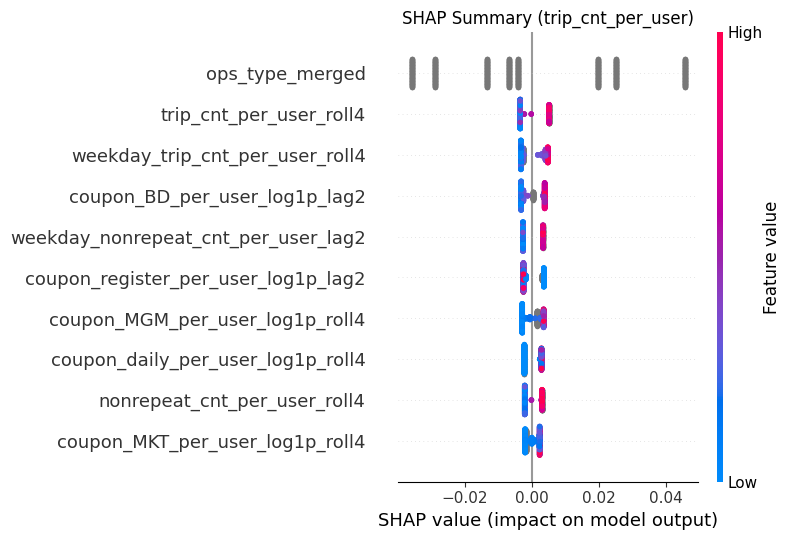

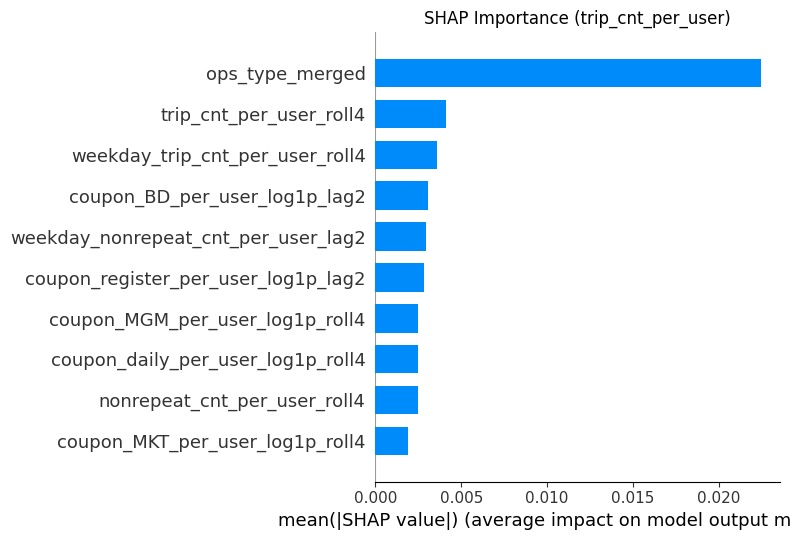

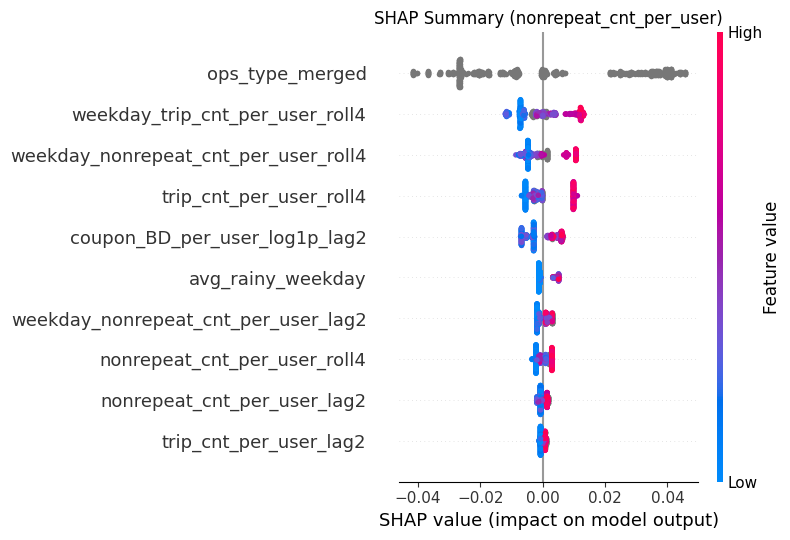

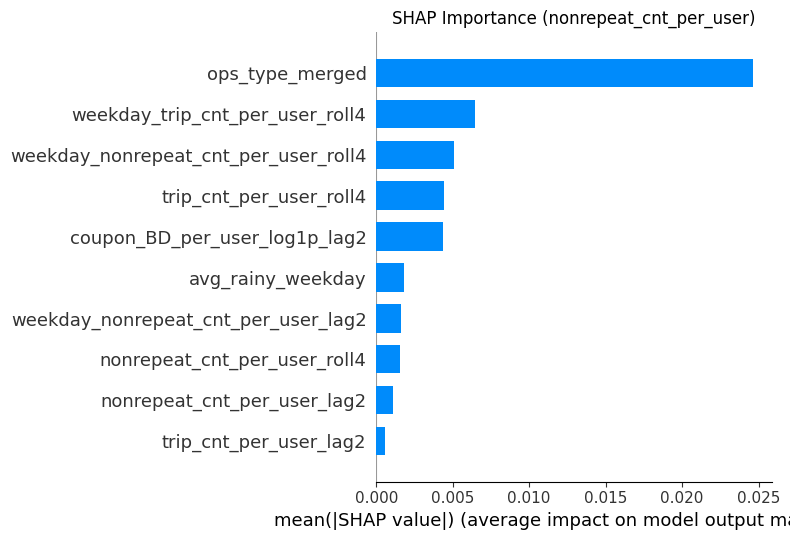

In [14]:
import numpy as np
import pandas as pd
import lightgbm as lgb
import shap
import matplotlib.pyplot as plt

# --------------------------
# Config (沿用你 prediction script)
# --------------------------
DATA_PATH = "../../final_data/data_260125_control.csv"
DATE_COL = "experiment_date"
TEST_WEEK = pd.Timestamp("2026-01-05")

Y1 = "trip_cnt_per_user"
Y2 = "nonrepeat_cnt_per_user"

CAT_COLS = ["ops_type_merged", "city_group"]

NUM_FEATURES = [
    "avg_rainy_day","avg_rainy_weekday","avg_rainy_weekend","mgm_day",
    "nonrepeat_cnt_per_user_lag2","nonrepeat_cnt_per_user_roll4",
    "trip_cnt_per_user_lag2","trip_cnt_per_user_roll4",
    "weekday_nonrepeat_cnt_per_user_lag2","weekday_nonrepeat_cnt_per_user_roll4",
    "weekday_trip_cnt_per_user_lag2","weekday_trip_cnt_per_user_roll4",
    "weekday_match_rate_lag2","weekday_match_rate_roll4",
    "weekend_nonrepeat_cnt_per_user_lag2","weekend_nonrepeat_cnt_per_user_roll4",
    "weekend_trip_cnt_per_user_lag2","weekend_trip_cnt_per_user_roll4",
    "weekend_match_rate_lag2","weekend_match_rate_roll4",
    "has_national_holiday",
    "coupon_BD_per_user_log1p_lag2","coupon_BD_per_user_log1p_roll4",
    "coupon_CDP_per_user_log1p_lag2","coupon_CDP_per_user_log1p_roll4",
    "coupon_folk_per_user_log1p_lag2","coupon_folk_per_user_log1p_roll4",
    "coupon_growth_other_per_user_log1p_lag2","coupon_growth_other_per_user_log1p_roll4",
    "coupon_MGM_per_user_log1p_lag2","coupon_MGM_per_user_log1p_roll4",
    "coupon_MKT_per_user_log1p_lag2","coupon_MKT_per_user_log1p_roll4",
    "coupon_register_per_user_log1p_lag2","coupon_register_per_user_log1p_roll4",
    "coupon_daily_per_user_log1p_lag2","coupon_daily_per_user_log1p_roll4",
    "delta_trip_per_user","delta_nonrepeat_per_user",
]

SHAP_SAMPLE_N = None   # 想用全量就改 None
MAX_DISPLAY = 10
RANDOM_STATE = 42

# --------------------------
# Load
# --------------------------
df = pd.read_csv(DATA_PATH)
df[DATE_COL] = pd.to_datetime(df[DATE_COL], errors="coerce")
df = df[df[DATE_COL].notna()].copy()
df = df[df[DATE_COL] <= TEST_WEEK].copy()

# categorical cast（只處理你模型會用到的 CAT_COLS）
for c in CAT_COLS:
    if c in df.columns:
        df[c] = df[c].astype("category")

# feature availability check（缺的就直接丟掉）
X_COLS = [c for c in CAT_COLS if c in df.columns] + [c for c in NUM_FEATURES if c in df.columns]
CAT_IN_X = [c for c in CAT_COLS if c in df.columns]

train_df = df[df[DATE_COL] < TEST_WEEK].copy()
if train_df.empty:
    raise ValueError("Train set is empty. TEST_WEEK may be too early.")

# y missing -> drop
train_y1 = train_df[train_df[Y1].notna()].copy()
train_y2 = train_df[train_df[Y2].notna()].copy()

def align_categories_inplace(trainX: pd.DataFrame, otherX: pd.DataFrame, cat_cols):
    # 讓 otherX 的 category levels 跟 trainX 一致
    for c in cat_cols:
        if c in trainX.columns and c in otherX.columns:
            trainX[c] = trainX[c].astype("category")
            otherX[c] = otherX[c].astype("category")
            otherX[c] = otherX[c].cat.set_categories(trainX[c].cat.categories)
    return trainX, otherX

# --------------------------
# Params (Optuna best)
# --------------------------
try:
    base_params = dict(
        objective="regression",
        random_state=RANDOM_STATE,
        n_jobs=-1,
        verbose=-1,
    )
    best_params_y1 = dict(base_params); best_params_y1.update(study_trip.best_params)
    best_params_y2 = dict(base_params); best_params_y2.update(study_nonrepeat.best_params)
except NameError:
    raise NameError(
        "找不到 study_trip / study_nonrepeat。\n"
        "請先跑完 optuna，或把 best_params dict 直接貼到 best_params_y1 / best_params_y2。"
    )

# --------------------------
# Train models USING EXACT SAME X_COLS (白名單)
# --------------------------
X1_train = train_y1[X_COLS].copy()
y1_train = train_y1[Y1].astype(float).values

X2_train = train_y2[X_COLS].copy()
y2_train = train_y2[Y2].astype(float).values

# ensure categories consistent within each target's training set
#（只要 X 內含 category，LightGBM 會用它）
for c in CAT_IN_X:
    X1_train[c] = X1_train[c].astype("category")
    X2_train[c] = X2_train[c].astype("category")

m_y1 = lgb.LGBMRegressor(**best_params_y1)
m_y2 = lgb.LGBMRegressor(**best_params_y2)

m_y1.fit(X1_train, y1_train, categorical_feature=CAT_IN_X)
m_y2.fit(X2_train, y2_train, categorical_feature=CAT_IN_X)

# ✅ 最重要：確認 SHAP 用到的 feature 完全等於模型 feature
assert list(m_y1.booster_.feature_name()) == list(X1_train.columns)
assert list(m_y2.booster_.feature_name()) == list(X2_train.columns)

# --------------------------
# SHAP sample
# --------------------------
def sample_X(X, n, seed=42):
    if n is None or n >= len(X):
        return X
    return X.sample(n, random_state=seed)

X1_shap = sample_X(X1_train, SHAP_SAMPLE_N, seed=42)
X2_shap = sample_X(X2_train, SHAP_SAMPLE_N, seed=42)

# --------------------------
# Compute + Plot SHAP
# --------------------------
expl1 = shap.TreeExplainer(m_y1)
expl2 = shap.TreeExplainer(m_y2)

sv1 = expl1.shap_values(X1_shap)
sv2 = expl2.shap_values(X2_shap)

plt.figure()
shap.summary_plot(sv1, X1_shap, show=False, max_display=MAX_DISPLAY)
plt.title("SHAP Summary (trip_cnt_per_user)")
plt.tight_layout()
plt.show()

plt.figure()
shap.summary_plot(sv1, X1_shap, plot_type="bar", show=False, max_display=MAX_DISPLAY)
plt.title("SHAP Importance (trip_cnt_per_user)")
plt.tight_layout()
plt.show()

plt.figure()
shap.summary_plot(sv2, X2_shap, show=False, max_display=MAX_DISPLAY)
plt.title("SHAP Summary (nonrepeat_cnt_per_user)")
plt.tight_layout()
plt.show()

plt.figure()
shap.summary_plot(sv2, X2_shap, plot_type="bar", show=False, max_display=MAX_DISPLAY)
plt.title("SHAP Importance (nonrepeat_cnt_per_user)")
plt.tight_layout()
plt.show()
